# Load Data

In [73]:
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('https://raw.githubusercontent.com/majickdave/dji_vol/master/dji.csv', 
                 header=1, 
                 usecols=[1,2,3,4])

df.head()

,Date,Dow Jones value,RIS Forecast Volume,RIS Actual Volume
0,1/4/2016,17148.94,6547,6886
1,1/5/2016,17158.66,4328,4928
2,1/6/2016,16906.51,3987,3713
3,1/7/2016,16514.10,4006,3910
4,1/8/2016,16346.45,4107,3797


# Process Data

In [74]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].describe(datetime_is_numeric=True)

count                             1160
mean     2018-04-23 17:19:02.068977664
min                2016-01-04 00:00:00
25%                2017-02-27 18:00:00
50%                2018-04-23 12:00:00
75%                2019-06-20 06:00:00
max                2020-08-13 00:00:00
Name: Date, dtype: object

# Create Training Data and Fit Model

In [75]:
df = df[['Date','RIS Actual Volume']]

#  pre-format for prophet
df.columns = ['ds','y']

# set start date of training data
df = df[df['ds'] >= '2018-07-01']
df.head()

,ds,y
628,2018-07-02,2890
629,2018-07-03,2190
630,2018-07-05,2460
631,2018-07-06,2440
632,2018-07-09,3225


In [76]:
# create default prophet model
m = Prophet(weekly_seasonality=True, yearly_seasonality=True)
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


# Create future dates

In [77]:
future = m.make_future_dataframe(periods=100)
future.tail()

,ds
627,2020-11-17
628,2020-11-18
629,2020-11-19
630,2020-11-20
631,2020-11-21


# Make Predicitons on future dates

In [78]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
627,2020-11-17,2315.272323,1826.700879,2806.446270
628,2020-11-18,2128.655343,1678.631877,2621.414770
629,2020-11-19,2045.308447,1555.931628,2537.663790
630,2020-11-20,2141.718282,1677.756446,2628.747580
631,2020-11-21,2369.718388,1873.904344,2884.713665


# Visualize Data

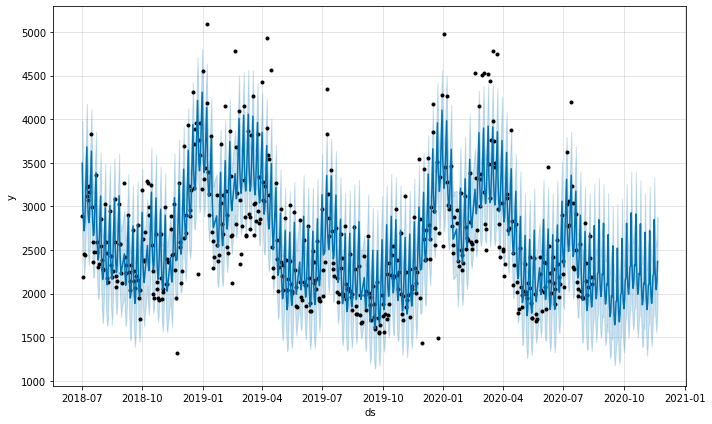

In [79]:
fig1 = m.plot(forecast)

# plot seasonality and analyze trends

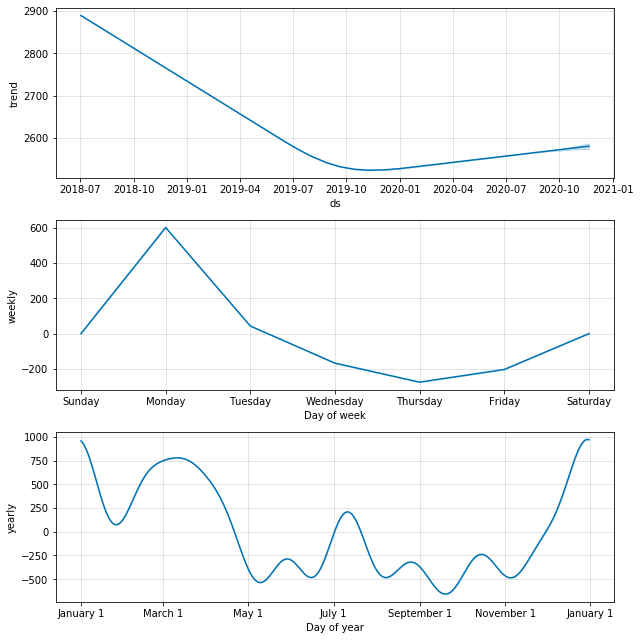

In [80]:
fig2 = m.plot_components(forecast)

# Calculate metrics for original model and prophet 
from dates 2020-8-17 through 2020-10-13

In [81]:
## Load current volume and forecast

df2 = pd.read_csv('ris_forecast.csv', usecols=[0,1,2,3])
df2['date'] = pd.to_datetime(df2['date'])
df2.head()

,date,RECEIVED,FORECAST,HANDLED
0,2020-08-17,2404,2542,2274
1,2020-08-18,1922,2057,1764
2,2020-08-19,1926,1874,1779
3,2020-08-20,1769,1790,1724
4,2020-08-21,1933,1842,1643


In [82]:
# create forecast window
f = forecast[(forecast['ds']>='2020-08-17') & (
    forecast['ds']<'2020-10-14')][['ds','yhat', 'yhat_lower', 'yhat_upper']]

# get rid of holiday and weekend
f = f[~f['ds'].dt.weekday.isin([5,6])]

# drop labor day 2020
f = f[f['ds']!='2020-09-07']

In [83]:
# validate forecast dates equals actual dates
print(df2.shape[0] == f.shape[0])

# validate all dates for forecast equal actual dates
print(all(df2['date'].dt.date.values == f['ds'].dt.date.values))

True
True


In [84]:
# join actual and current forecast
f['actual'] = df2['RECEIVED'].values

f['forecast'] = df2['FORECAST'].values

In [85]:
def get_error(f, metric='MAPE'):
    """
    take in a dataframe f, of predictions, y_hat,
    and a list of actuals, y and return
    a float
    """
    res = {}
    if metric == 'MAPE':
        res['prophet'] = abs((f['yhat']-f['actual'])/f['actual']).mean()
        res['forecast'] = abs((f['forecast']-f['actual'])/f['actual']).mean()
    else:
        res['prophet'] = ((f['yhat']-f['actual'])**2).sum()/f.shape[0]
        res['forecast'] = ((f['forecast']-f['actual'])**2).sum()/f.shape[0]
    
    return pd.DataFrame(res, index=[metric])

display(get_error(f))
rmse = get_error(f, metric='RMSE')
display(rmse)
    

,prophet,forecast
MAPE,0.074187,0.082129


,prophet,forecast
RMSE,50742.075529,55128.902439


## Both MAPE and RMSE are lower for the prophet model

resulting in an average of approximately 107 calls per day for the RIS group. 

In [86]:
# calculate average difference between forecast and model
(rmse['forecast'] - rmse['prophet']) / f.shape[0]

RMSE    106.995778
dtype: float64

# Future Work

1. determine most important metric for forecasting in each business unit
    - tune hyperparameters of prophet model
    - create different training and testing datasets (windows of time)

2. create forecasts for handle time
    - repeat step 1

3. Create forecasts for other metrics
    - repeat step 1
